# Todo list

1. one_hot √

* mini-batch

* normalization

* train/dev/test set √

* linear function √

* sigmoid function

* tanh function

* relu function √

* softmax function √

* loss function √

* cost function ?

* regularization

* drop out

* batch normalization

* momentum

* exponentially moving average

* Adam

* all backpropagation of above

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from test import *

In [2]:
from pprint import pprint
""" helper functions """
def names_in(dictionary):
    """ list all names in a dictionary """
    print([name for name,_ in sorted(dictionary.items())])
def names_shape_in(dictionary):
    pprint([(name, val.shape) for name,val in sorted(dictionary.items())])

def debug_show_all_variables():
    print("cache: ", end='')
    names_shape_in(cache)
    print("parameters: ", end='')
    names_shape_in(parameters)
    print("hyper_parameters: ", end='')
    names_in(hyper_parameters)

In [3]:
def load_mnist():
    import struct
    from array import array
    """ 
    load MNIST dataset into numpy array 
    MNIST dataset can be downloaded manually.
    url: http://yann.lecun.com/exdb/mnist/
    """
    ret = {}
    with open('MNIST/train-images.idx3-ubyte', 'rb') as f:
        magic, size, rows, cols = struct.unpack(">IIII", f.read(16))
        assert(magic==2051)
        ret['X_train'] = np.array(array("B", f.read())).reshape(size,rows,cols)

    with open('MNIST/t10k-images.idx3-ubyte', 'rb') as f:
        magic, size, rows, cols = struct.unpack(">IIII", f.read(16))
        assert(magic==2051)
        ret['X_test'] = np.array(array("B", f.read())).reshape(size,rows,cols)

    with open('MNIST/train-labels.idx1-ubyte', 'rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        assert(magic==2049)
        ret['Y_train'] = np.array(array("B", f.read())).reshape(size,1)

    with open('MNIST/t10k-labels.idx1-ubyte', 'rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        assert(magic==2049)
        ret['Y_test'] = np.array(array("B", f.read())).reshape(size,1)

    return ret

In [4]:
mnist_original = load_mnist()

""" random shuffle the training set """
np.random.seed(1)
permutation = np.random.permutation(mnist_original['X_train'].shape[0])
mnist_original['X_train'] = mnist_original['X_train'][permutation]
mnist_original['Y_train'] = mnist_original['Y_train'][permutation]

""" divide trainset into trainset and devset """
len_of_dev = 10000
mnist_original['X_dev'] = mnist_original['X_train'][:len_of_dev]
mnist_original['Y_dev'] = mnist_original['Y_train'][:len_of_dev]
mnist_original['X_train'] = mnist_original['X_train'][len_of_dev:]
mnist_original['Y_train'] = mnist_original['Y_train'][len_of_dev:]

print('X_train:', mnist_original['X_train'].shape,
      'X_dev:', mnist_original['X_dev'].shape,
      'X_test:', mnist_original['X_test'].shape)
print('Y_train:', mnist_original['Y_train'].shape,
      'Y_dev:', mnist_original['Y_dev'].shape,
      'Y_test:', mnist_original['Y_test'].shape)

X_train: (50000, 28, 28) X_dev: (10000, 28, 28) X_test: (10000, 28, 28)
Y_train: (50000, 1) Y_dev: (10000, 1) Y_test: (10000, 1)


In [5]:
def manually_validate_dataset(dataset):
    random_train = np.random.randint(1, len(dataset['X_train']))-1
    random_dev = np.random.randint(1, len(dataset['X_dev']))-1
    random_test = np.random.randint(1, len(dataset['X_test']))-1
    print(dataset['Y_train'][random_train], dataset['Y_dev'][random_dev], dataset['Y_test'][random_test])
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, figsize=[10,3])
    ax1.imshow(dataset['X_train'][random_train], cmap='gray')
    ax2.imshow(dataset['X_dev'][random_dev], cmap='gray')
    ax3.imshow(dataset['X_test'][random_test], cmap='gray')
    plt.show()

#manually_validate_dataset(mnist_original)

$$ X = 
\begin{bmatrix}
\vert & & \vert & & \vert \\
x^{(1)} & ... & x^{(i)} & ... & x^{(m)} \\
\vert & & \vert & & \vert
\end{bmatrix} 
\quad \quad
Y = 
\begin{bmatrix}
\vert & & \vert & & \vert \\
y_{one\_hot}^{(1)} & ... & y_{one\_hot}^{(i)} & ... & y_{one\_hot}^{(m)} \\
\vert & & \vert & & \vert \\
\end{bmatrix}
$$

In [6]:
mnist = {}

""" X is 28*28 image """
def flatten(X):
    """ prepare X to (nx, m) shape """
    X = X.reshape(-1, 28*28).T
    return X

def normalize(X):
    u = 0
    sigma = 255
    return (X-u) / sigma

mnist['X_train'] = normalize(flatten(mnist_original['X_train']))
mnist['X_dev'] = normalize(flatten(mnist_original['X_dev']))
mnist['X_test'] = normalize(flatten(mnist_original['X_test']))

""" Y is label 0-9 """
def one_hot(Y, C):
    """ prepare Y to (1, m) shape """
    assert(Y.shape[1]==1)
    Y_ret = np.zeros((Y.shape[0], C))
    Y_ret[np.arange(Y.shape[0]), Y.reshape(-1).astype(int)] = 1
    Y_ret = Y_ret.T
    return Y_ret

def back_one_hot(Y):
    """ convert one hot Y back to real number """
    Y_ret = np.repeat( [np.arange(Y.shape[0])], repeats=Y.shape[1], axis=0 )
    assert(Y_ret.shape == Y.T.shape)
    Y_ret = Y_ret[Y.T.astype(bool)]
    return Y_ret.reshape(-1,1)

mnist['Y_train'] = one_hot(mnist_original['Y_train'], 10)
mnist['Y_dev'] = one_hot(mnist_original['Y_dev'], 10)
mnist['Y_test'] = one_hot(mnist_original['Y_test'], 10)

print(mnist['X_train'].shape, mnist['Y_train'].shape)

(784, 50000) (10, 50000)


In [7]:
""" init cache, parameters and hyper_parameters """
def init(X_size, hidden_layers=[10,10,5], C=10, learning_rate=0.01):
    global cache, parameters, hyper_parameters
    cache = {}
    parameters = {}
    hyper_parameters = {}
    initialize_hyper_parameters(X_size, hidden_layers, C, learning_rate)
    initialize_parameters()

def initialize_hyper_parameters(X_size, hidden_layers, C, learning_rate):
    global hyper_parameters
    hyper_parameters['X_size'] = X_size
    # layers of network, include the last softmax layer
    # hidden layers use ReLU activation function, and the last layer use Softmax function
    hyper_parameters['layers'] = hidden_layers + [C]
    # L layers in total
    hyper_parameters['L'] = len(hyper_parameters['layers'])
    # Class numbers 0-9 is 10
    hyper_parameters['C'] = C
    hyper_parameters['learning_rate'] = learning_rate

def initialize_parameters():
    """ init W b or any other parameters in every layer """
    global parameters, hyper_parameters
    layers = hyper_parameters['layers']
    x_size = hyper_parameters['X_size']
    cells_prev = x_size
    for layer_idx, cells in enumerate(layers):
        parameters['W'+str(layer_idx+1)] = np.random.randn(cells, cells_prev) * 0.01
        parameters['b'+str(layer_idx+1)] = np.zeros((cells, 1))
        cells_prev = layers[layer_idx]

$$
ReLu = max(0, x)
\quad \quad
Softmax = \frac{\exp(Z)}{\sum_i^n{\exp(Z)}}
$$
***
$$
Z = W X + b
\quad \quad
A = active(Z)
$$

In [8]:
def ReLU(X):
    return X * (X > 0)

def softmax(X):
    s = np.sum(np.exp(X), axis=0)
    return np.exp(X) / s

def forward_propagation_each_layer(W, A_prev, b, activation_function=ReLU):
    Z = np.dot(W, A_prev) + b
    A = activation_function(Z)
    return Z,A

This is logistic regression loss:
$$
L(\hat{y}, y) = -\frac{1}{m} \sum_i^m{(y_i\log(\hat{y}_i) + (1-y_i)\log(1-\hat{y}_i))}
$$

This is multi-class classification loss:
$$
L(\hat{y}, y) = -\frac{1}{m} \sum_i^m \sum_j^C (y_j^{(i)}\log(\hat{y}_j^{(i)}))
$$
where m is batch size, C is class number (10 classes), (i) is the i-th example, j is the vertical bit of result.

In [9]:
def loss(Y_hat, Y):
    A = np.multiply(Y, np.log(Y_hat))
    B = np.multiply(1-Y, np.log(1-Y_hat))
    Loss = -A-B
    #why not use Loss = -np.sum(A+B) / m?
    return Loss

def cost(loss):
    return np.mean(loss)

In [10]:
def predict(Y_hat):
    return np.argmax(Y_hat,axis=0).reshape(-1,1)

def accuracy(Y_predict, Y):
    return np.sum(np.equal(Y_predict, back_one_hot(Y))) / Y_predict.shape[0]

# This formula is wrong, This is the logistic regression(binary classifier) Loss


We already know L formula above:
$$
L = -\frac{1}{m} \sum_i^{m}[y^{(i)} log(\hat{y}^{(i)}) + (1-y^{(i)}) log(1-\hat{y}^{(i)})]
$$
***
$$
A^{[L]} = \hat{Y} = 
\begin{bmatrix}
\hat{y}^{(1)} & ... & \hat{y}^{(m)} 
\end{bmatrix}
\quad, \quad
Y =
\begin{bmatrix}
y^{(1)} & ... & y^{(m)}
\end{bmatrix}
$$
***
So:
$$
\textbf{dAL} = \frac{\partial L}{\partial A^{[L]}}
= - \frac{1}{m} ( \frac{Y}{A^{[L]}} - \frac{1-Y}{1-A^{[L]}} )
= \frac{A^{[L]}-Y}{m A^{[L]}(1-A^{[L]})}
$$

in which **dAL** represents the Python Variable.


In [11]:
def backpropagate_cost(Y, AL):
    #m = Y.shape[1] #why not 1/m?
    #dAL = -np.divide(Y, AL) #why not use this formula?
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    return dAL

$$
\textbf{dZL}
= \frac{\partial L}{\partial Z^{[L]}}
= \frac{\partial L}{\partial A^{[L]}} \frac{\partial A^{[L]}}{\partial Z^{[L]}}
= \textbf{dAL} * \frac{\partial A^{[L]}}{\partial Z^{[L]}}
$$
***
$$
\frac{\partial A^{[L]}}{\partial Z^{[L]}}
= A^{[L]} - (A^{[L]})^{2}
$$
***
$$
\textbf{dZL} = \textbf{dAL} * (\textbf{AL} - \textbf{AL}^{2})
$$

In [12]:
def backpropagate_softmax(AL, dAL, Y=None, ZL=None):
    dZ = np.multiply(dAL, (AL-np.power(AL,2)))
    return dZ

$$
\because
$$
$$
Z^{[l]} = W^{[l]} * A^{[l-1]} + b^{[l]}
$$
***
$$
\textbf{dZ} = \frac{\partial L}{\partial Z^{[l]}}
$$
***
$$
\therefore
$$
$$
\textbf{dA\_prev} 
= \frac{\partial L}{\partial A^{[l-1]}}
= \frac{\partial L}{\partial Z^{[l]}} \frac{\partial Z^{[l]}}{\partial A^{[l-1]}}
= \textbf{dZ} * W^{[l]}
$$
***
$$
\textbf{dW}
= \frac{\partial L}{\partial W^{[l]}}
= \frac{\partial L}{\partial Z^{[l]}} \frac{\partial Z^{[l]}}{\partial W^{[l]}}
= \textbf{dZ} * A^{[l-1]}
$$
***
$$
\textbf{db}
= \frac{\partial L}{\partial b^{[l]}}
= \frac{\partial L}{\partial Z^{[l]}} \frac{\partial Z^{[l]}}{\partial b^{[l]}}
= \textbf{dZ} * 1
$$

In [13]:
def backpropagate_linear(dZ, W, A_prev):
    m = dZ.shape[1] # I still don't know why move 1/m here from backpropagate_cost.
    dA_prev = np.dot(W.T, dZ)
    dW = 1/m * np.dot(dZ, A_prev.T)
    db = 1/m * np.sum(dZ, axis=1).reshape(-1,1)
    return dA_prev, dW, db

$$
\because
$$

$$
A^{[l]} = ReLU(Z^{[l]}) = max(0, Z^{[l]})
$$
***
$$
\therefore
$$

$$
\textbf{dZ}
= \frac{\partial L}{\partial Z^{[l]}}
= \frac{\partial L}{\partial A^{[l]}} \frac{\partial A^{[l]}}{\partial Z^{[l]}}
= \textbf{dA} * ReLU^{-1}(Z^{[l]})
= \textbf{dA} * 
\begin{bmatrix}
1 (z \geq 0)\\
0 (z < 0)
\end{bmatrix}
$$

In [14]:
def backpropagate_ReLU(dA, Z):
    return np.multiply(dA, (Z>=0).astype(np.float32))

In [15]:
""" neural network logic level """

def forwardpropagation_all(X):
    global cache, parameters, hyper_parameters
    layers = hyper_parameters['layers']
    A_prev = X
    for layer_idx, cells in enumerate(layers):
        W = parameters['W'+str(layer_idx+1)]
        b = parameters['b'+str(layer_idx+1)]
        if layer_idx==len(layers)-1:
            # Last layer's activation function should be softmax
            Z, A = forward_propagation_each_layer(W, A_prev, b, softmax)
        else:
            Z, A = forward_propagation_each_layer(W, A_prev, b)
        cache['Z'+str(layer_idx+1)] = Z
        cache['A'+str(layer_idx+1)] = A
        A_prev = A

def backpropagate_all(X, Y):
    global mnist, cache, parameters, hyper_parameters
    # 1. Last layer has coss function and softmax function
    L = str(hyper_parameters['L'])
    cache['dA'+L] = backpropagate_cost(Y,cache['A'+L])
    AL = cache['A'+L]
    dAL = cache['dA'+L]
    cache['dZ'+L] = backpropagate_softmax(AL, dAL)

    # 2. Layers in between are similar: linear and ReLU
    for i in np.arange(start=hyper_parameters['L']-1, stop=0, step=-1):
        L = str(i)
        cache['dA'+L], cache['dW'+str(i+1)], cache['db'+str(i+1)] = backpropagate_linear(cache['dZ'+str(i+1)], 
                                                                           parameters['W'+str(i+1)], 
                                                                           cache['A'+L])
        cache['dZ'+L] = backpropagate_ReLU(cache['dA'+L], cache['Z'+L])

    # 3. First layer has different parameter.
    _, cache['dW1'], cache['db1'] = backpropagate_linear(cache['dZ1'], parameters['W1'], X)

def update_parameters():
    global cache, parameters
    for i in range(hyper_parameters['L']):
        L = str(i+1)
        parameters['W'+L] -= cache['dW'+L] * hyper_parameters['learning_rate']
        parameters['b'+L] -= cache['db'+L] * hyper_parameters['learning_rate']

0 > training error =  0.325038366892 ; accu = 0.078125
30 > training error =  0.31792193448 ; accu = 0.1796875
60 > training error =  0.295007319198 ; accu = 0.1796875
90 > training error =  0.233226486235 ; accu = 0.4765625
120 > training error =  0.149351638568 ; accu = 0.8203125
150 > training error =  0.0862896958758 ; accu = 0.9296875
180 > training error =  0.0488487100112 ; accu = 0.984375
210 > training error =  0.028338181132 ; accu = 1.0
240 > training error =  0.0171974913036 ; accu = 1.0
270 > training error =  0.0111907814449 ; accu = 1.0


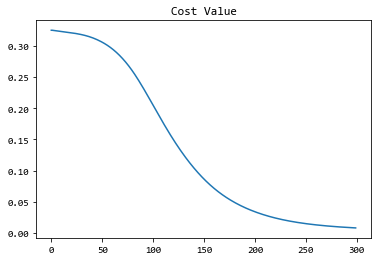

In [19]:
def model(X, Y, learning_rate=0.01, print_every=100, iteration=500, hidden_layers=[100], batch_size=128):
    init(hidden_layers=hidden_layers, C=Y.shape[0], X_size=X.shape[0], learning_rate=learning_rate)
    # costs will be returned for plotting
    costs = []
    X_full = X
    Y_full = Y
    np.random.seed(1)
    for i in range(iteration):
        permutation = np.random.permutation(X.shape[1])
        X = X_full[:, permutation]
        X = X[:, :batch_size]
        Y = Y_full[:, permutation]
        Y = Y[:, :batch_size]
        
        forwardpropagation_all(X)
        Y_hat = cache['A'+str(hyper_parameters['L'])]
        cost_value = cost(loss(Y_hat, Y))
        costs.append(cost_value)
        if i%print_every==0:
            Y_predict = predict(Y_hat)
            accu = accuracy(Y_predict, Y)
            print(i,'> training error = ',cost_value,'; accu =',accu)
        backpropagate_all(X, Y)
        update_parameters()
        if np.isnan(cost_value):
            print("ERROR to nan!!!")
            break
    return costs

def test_model():
    m = 10
    X = np.random.randn(784,m)
    Y = one_hot(np.random.randint(low=0, high=10, size=(m,1)), C=10)
    #print(X[:,1])
    #print(Y[:,1])
    costs = model(X,Y,learning_rate=0.1, print_every=10, iteration=100,
                 hidden_layers=[10,10])
    plt.plot(costs)
    plt.show()
def test_model_1():
    costs = model(mnist['X_train'], mnist['Y_train'], 
                  learning_rate=0.1, print_every=30, iteration=300,
                  batch_size=128,
                  hidden_layers=[784,1000])
    plt.plot(costs)
    plt.title("Cost Value")
    plt.show()

test_model_1()
#model(mnist['X_train'], mnist['Y_train'])

In [17]:
debug_show_all_variables()

cache: [('A1', (784, 128)),
 ('A2', (1000, 128)),
 ('A3', (10, 128)),
 ('Z1', (784, 128)),
 ('Z2', (1000, 128)),
 ('Z3', (10, 128)),
 ('dA1', (784, 128)),
 ('dA2', (1000, 128)),
 ('dA3', (10, 128)),
 ('dW1', (784, 784)),
 ('dW2', (1000, 784)),
 ('dW3', (10, 1000)),
 ('dZ1', (784, 128)),
 ('dZ2', (1000, 128)),
 ('dZ3', (10, 128)),
 ('db1', (784, 1)),
 ('db2', (1000, 1)),
 ('db3', (10, 1))]
parameters: [('W1', (784, 784)),
 ('W2', (1000, 784)),
 ('W3', (10, 1000)),
 ('b1', (784, 1)),
 ('b2', (1000, 1)),
 ('b3', (10, 1))]
hyper_parameters: ['C', 'L', 'X_size', 'layers', 'learning_rate']
